# Environment

In [1]:
import os
import cv2
import random

from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt


from pathlib import Path
# from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torchvision import transforms
from torchvision.transforms import functional as TF
from torchvision.transforms import ToTensor, Grayscale, Resize

from torch.utils.data import Dataset, DataLoader    

from efficientnet_pytorch import EfficientNet

C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: ''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [13]:
# Path to the data directory
data_dir = Path("data_v1/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))


print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  113062
Number of labels found:  113062
Number of unique characters:  60
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [3]:
# Desired image dimensions
img_width = 200
img_height = 50

# Preprocessing

In [4]:
# Mapping characters to integers
char_to_num = nn.Embedding(len(characters), 1)
# Mapping integers back to original characters
num_to_char = nn.EmbeddingBag(len(characters), 1).

In [5]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

def encode_single_sample(img_path, label):
    img = Image.open(img_path).convert("RGB")
    img = np.array(img) / 255.0
    img = cv2.resize(img, (img_width, img_height))
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
    
    char_to_idx = {char: idx for idx, char in enumerate(characters)}
    label = [char_to_idx[char] for char in label]
    label = torch.tensor(label, dtype=torch.long)
    
    return {"image": img, "label": label}

In [6]:
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

# Visualize 

In [7]:
def decode_label(label):
    decoded_label = ""
    for char in label:
        if char in characters:
            decoded_label += char
    return decoded_label

<Figure size 800x1200 with 0 Axes>

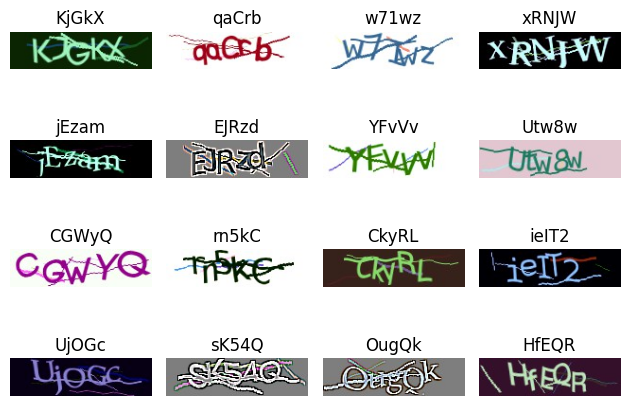

In [8]:
# Đặt kích thước của cửa sổ output
plt.figure(figsize=(8, 12))  # Điều chỉnh kích thước cửa sổ theo mong muốn

# Lấy các chỉ số ngẫu nhiên
random_indices = random.sample(range(len(images)), 16)

# Lấy các ảnh và nhãn ngẫu nhiên
random_images = [images[i] for i in random_indices]
random_labels = [labels[i] for i in random_indices]

# Giải mã các nhãn
decoded_labels = [decode_label(label) for label in random_labels]

# Tạo lưới subplot
num_rows = 4
num_cols = len(random_images) // num_rows
fig, axes = plt.subplots(num_rows, num_cols)

# Hiển thị ảnh và nhãn trong các subplot
for i, (image, label, decoded_label) in enumerate(zip(random_images, random_labels, decoded_labels)):
    ax = axes[i // num_cols, i % num_cols]
    image_data = plt.imread(image)
    ax.imshow(image_data, cmap='gray')
    ax.set_title(decoded_label)
    ax.axis('off')

# Điều chỉnh khoảng cách giữa các subplot
plt.tight_layout()

# Hiển thị đồ thị
plt.show()


# Create Dataset objects

In [7]:
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = self.images[index]
        label = self.labels[index]
        sample = encode_single_sample(img_path, label)
        return sample

In [9]:
train_dataset = CustomDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

validation_dataset = CustomDataset(x_valid, y_valid)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

In [10]:
train_loader_iter = iter(train_loader)
batch = next(train_loader_iter)
images, labels = batch['image'], batch['label']
print("Kích thước ảnh:", images.size())
print("Kích thước nhãn:", labels.size())

Kích thước ảnh: torch.Size([64, 3, 50, 200])
Kích thước nhãn: torch.Size([64, 5])


In [271]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Feature Extracting with EfficientNet_B0

In [15]:
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [ ]:
# model.eval()
model.to(device)

In [17]:
# Tạo một file để lưu đặc trưng
output_file = 'features_with_label'

# Tạo một danh sách rỗng để lưu trữ labels
all_labels = []

# Tạo danh sách rỗng để lưu trữ features
all_features = []

total_batches = len(train_loader)
for batch_idx, sample in enumerate(tqdm(train_loader, total=total_batches)):
    images = sample['image']
    labels = sample['label']
    
    # Chuyển dữ liệu (images và labels) lên GPU
    images = images.to(device)

    with torch.no_grad():
        features = model.extract_features(images)
    
    # Xử lý đặc trưng trích xuất nếu cần
    flattened_features = features.view(features.size(0), -1)

    # Thêm đặc trưng vào danh sách tất cả các đặc trưng
    all_features.append(flattened_features.cpu().numpy())

    # Thêm nhãn vào danh sách tất cả các nhãn
    all_labels.extend(labels)

# Gộp tất cả các đặc trưng và nhãn thành các mảng numpy
all_features = np.concatenate(all_features, axis=0)
all_labels = np.array(all_labels)

# Lưu đặc trưng và nhãn vào cùng một file
np.savez(output_file, features=all_features, labels=all_labels)

print("Trích xuất đặc trưng và lưu vào file thành công!")

100%|██████████| 1590/1590 [04:07<00:00,  6.42it/s]
C:\Users\Admin\AppData\Local\Temp\ipykernel_8680\2946700272.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  all_labels = np.array(all_labels)
C:\Users\Admin\AppData\Local\Temp\ipykernel_8680\2946700272.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_labels = np.array(all_labels)


Trích xuất đặc trưng và lưu vào file thành công!


# RNN & CTC

### DATA

In [184]:
# Đọc file chứa cả features và labels
data = np.load('features_with_label.npz', allow_pickle=True)
features = data['features']
labels = data['labels']

# Maximum length of any captcha in the dataset
sequence_length = max([len(label) for label in labels])
sequence_length

5

In [185]:
# Kiểm tra kích thước và cấu trúc của đặc trưng và nhãn
print("Kích thước đặc trưng", features.shape)
print("Kích thước của nhãn:", labels.shape)

Kích thước đặc trưng (101755, 7680)
Kích thước của nhãn: (101755,)


In [186]:
# Thêm sequence_length vào features
features_tensor = torch.from_numpy(features)
new_features = features_tensor.reshape(features.shape[0], 1, features.shape[1]).expand(features.shape[0], sequence_length,  features.shape[1])
new_features.shape

torch.Size([101755, 5, 7680])

In [187]:
class CustomFeatureset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

In [188]:
# Tạo một CustomDataset mới từ features và labels đã đọc từ file
features_set = CustomFeatureset(new_features, labels)
# Tạo DataLoader từ CustomDataset
features_loader = DataLoader(features_set, batch_size=64, shuffle=True)
for batch_idx, (f, l) in enumerate(features_loader):
    a=1

In [32]:
print("Batch index:", batch_idx+1)
print("Kích thước của 1 đặc trưng cuối trong batch:", f.size())
print("Kích thước của 1 nhãn cuối trong batch:", l.size())

Batch index: 1590
Kích thước của 1 đặc trưng cuối trong batch: torch.Size([59, 5, 7680])
Kích thước của 1 nhãn cuối trong batch: torch.Size([59, 5])


### Model

In [284]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes + 1)  # Thêm một lớp cho ký tự "blank"
        self.log_softmax = nn.LogSoftmax(dim=-1)  # Thêm lớp log_softmax

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.fc(hn[-1])
        out = out.unsqueeze(1).repeat(1, 5, 1)  # Lặp lại kết quả để có sequence length là 5
        out = self.log_softmax(out)
        return out


In [ ]:
# VÍ DỤ KIỂM TRA ĐẦU RA TÍNH TOÁN CỦA MÔ HÌNH
# input_size = 20
# hidden_size = 64
# num_layers = 2
# num_classes = 26

# # Tạo một batch mẫu
# batch_size = 3
# sequence_length = 10
# features = torch.randn(batch_size, sequence_length, input_size)

# # Khởi tạo mô hình LSTM
# model = LSTMModel(input_size, hidden_size, num_layers, num_classes)

# # Thực hiện tính toán đầu ra
# outputs = model(features)


# # In kích thước của đầu ra
# print(outputs.size())
# outputs

### Training

In [273]:
# Các thông số huấn luyện
input_size = 7680
hidden_size = 98
num_layers = 2

num_epochs = 5
batch_size = 64
learning_rate = 0.00000001

num_classes = len(characters)

In [279]:
# Tạo DataLoader từ CustomFeatureset
features_loader = DataLoader(features_set, batch_size=batch_size, shuffle=True)

# Khởi tạo mô hình LSTM và đưa lên GPU nếu có
model = LSTMModel(input_size, hidden_size, num_layers, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Định nghĩa hàm mất mát CTC Loss
ctc_loss = nn.CTCLoss()

# Khởi tạo bộ tối ưu hóa
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [278]:
total_batches = len(features_loader)
for epoch in range(num_epochs):
    for batch_idx, (features, labels) in enumerate(features_loader):
        batch_size = features.size(0)  # Lấy kích thước của batch
        features = features.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(features)

        # Tính toán độ dài đầu vào
        input_lengths = torch.full((batch_size,),features.size(1), dtype=torch.long).to(device)

        # Tính toán độ dài nhãn
        target_lengths = torch.full((batch_size,),labels.size(1), dtype=torch.long).to(device)

        # Tính toán CTC Loss
        loss = ctc_loss(outputs.transpose(0, 1), labels, input_lengths, target_lengths)

        # Backward pass và cập nhật gradient
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{total_batches}], Loss: {loss.item()}")

print("Huấn luyện mô hình thành công!")

Epoch [1/5], Batch [100/1590], Loss: nan
Epoch [1/5], Batch [200/1590], Loss: nan


KeyboardInterrupt: 

In [179]:
# np.savetxt('1_batch_size_feature.txt', features.cpu().reshape((3,-1)), fmt="%s", header=str(features.shape))

In [ ]:
features

In [269]:
print(outputs.transpose(0, 1).shape)
print(labels.shape)
print(input_lengths.shape)
print(target_lengths.shape)

torch.Size([5, 59, 61])
torch.Size([59, 5])
torch.Size([64])
torch.Size([64])


In [245]:
input_lengths

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0')